In [45]:
# Load the housing dataset given for free by google colab
df = pd.read_csv("/content/sample_data/california_housing_train.csv")

# Convert the DataFrame to a list of dictionaries -> so that it mimics JSON data in a request
data = df.to_dict(orient='records')
print(data
      )

Output hidden; open in https://colab.research.google.com to view.

In [39]:
#install libraries in google colab
!pip install Flask pandas scikit-learn matplotlib flask-cors

#General Guidelines
* Function Parameters: Accept data in a format that's easy to send via HTTP, such as JSON.
* Return Values: Return results in a format that's easy to serialize into JSON, such as dictionaries or lists.
*Flexibility: Allow parameters for configurable aspects, like the number of clusters

#Basic Data Analysis Button on the Frontend
The idea is that the end user can push this button and gets the visualizations below per data set before he decides to buy it or not

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import base64

def basic_data_analysis(data):
    df = pd.DataFrame(data)

    # Summary Statistics
    summary = df.describe().to_dict()

    # Missing Values
    missing_values = df.isnull().sum().to_dict()

    # Unique Values
    unique_values = df.nunique().to_dict()

    # Histograms
    histograms = {}
    for column in df.select_dtypes(include=['number']).columns:
        plt.figure()
        df[column].hist()
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')

        img = io.BytesIO()
        plt.savefig(img, format='png')
        img.seek(0)
        histograms[column] = base64.b64encode(img.getvalue()).decode()
        plt.close()

    # Correlation Matrix
    plt.figure(figsize=(10, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix')

    img = io.BytesIO()
    plt.savefig(img, format='png')
    img.seek(0)
    correlation_matrix = base64.b64encode(img.getvalue()).decode()
    plt.close()

    return {
        'summary': summary,
        'missing_values': missing_values,
        'unique_values': unique_values,
        'histograms': histograms,
        'correlation_matrix': correlation_matrix
    }



,count,mean,std,min,25%,50%,75%,max
longitude,17000.0,-119.562108,2.005166,-124.3500,-121.790000,-118.4900,-118.000,-114.3100
latitude,17000.0,35.625225,2.137340,32.5400,33.930000,34.2500,37.720,41.9500
housing_median_age,17000.0,28.589353,12.586937,1.0000,18.000000,29.0000,37.000,52.0000
total_rooms,17000.0,2643.664412,2179.947071,2.0000,1462.000000,2127.0000,3151.250,37937.0000
total_bedrooms,17000.0,539.410824,421.499452,1.0000,297.000000,434.0000,648.250,6445.0000
population,17000.0,1429.573941,1147.852959,3.0000,790.000000,1167.0000,1721.000,35682.0000
households,17000.0,501.221941,384.520841,1.0000,282.000000,409.0000,605.250,6082.0000
median_income,17000.0,3.883578,1.908157,0.4999,2.566375,3.5446,4.767,15.0001
median_house_value,17000.0,207300.912353,115983.764387,14999.0000,119400.000000,180400.0000,265000.000,500001.0000



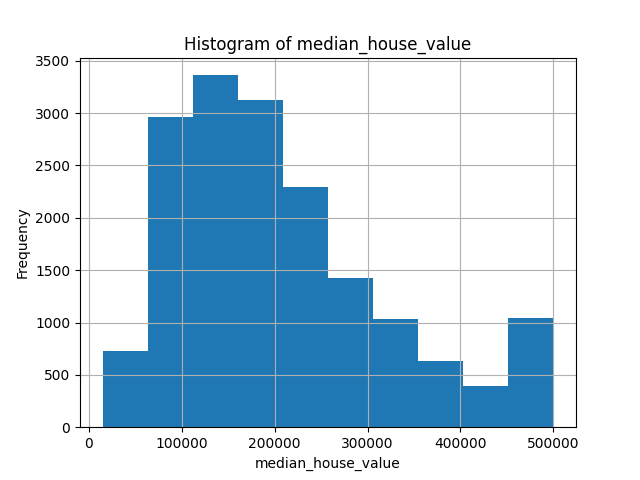


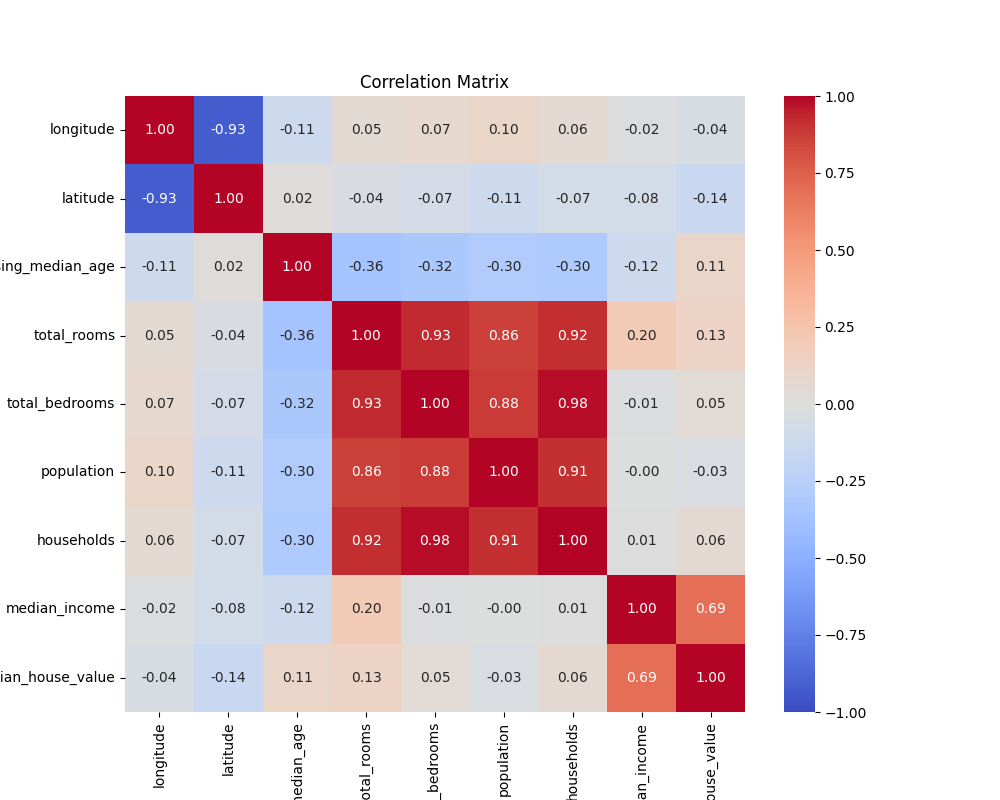

In [44]:
#this part of the code is solely for visualization purposes here -> do not use it in the flask app.
# Test basic data analysis function
basic_result = basic_data_analysis(data)

# Display the summary statistics as an HTML table
summary_html = pd.DataFrame(basic_result['summary']).T.to_html(classes='table table-striped', border=0)
from IPython.display import display, HTML
display(HTML(summary_html))

# Display one of the histograms (for example, the 'median_house_value' column)
display(HTML(f"<img src='data:image/png;base64,{basic_result['histograms']['median_house_value']}'/>"))

# Display the correlation matrix
display(HTML(f"<img src='data:image/png;base64,{basic_result['correlation_matrix']}'/>"))


#Advanced Data Analysis Buttons on the Frontend

* Button 1: PCA and feature importance of data set
* Button 2: k-means clustering
* Button 3: Tsne for advanced visualizations

##Button 1: PCA and feature importance of data set
PCA helps us define how much of the dataset variance is explained by which principal componnts if we decide to reduce the dimensions (features) of our datasets

In [46]:
from sklearn.decomposition import PCA
import pandas as pd

def pca_feature_importance(data, n_components=None):
    """
    Perform PCA on the provided dataset to determine feature importance.

    Parameters:
    data (list of dict): List of dictionaries containing the dataset.
    n_components (int): Number of principal components to compute. Default is None, which means all components are computed.

    Returns:
    dict: A dictionary containing the explained variance ratio and feature importance.
    """
    df = pd.DataFrame(data)
    numeric_features = df.select_dtypes(include='number').columns.tolist()
    selected_features = df[numeric_features]

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca.fit(selected_features)

    explained_variance_ratio = pca.explained_variance_ratio_
    feature_importance = pd.DataFrame(pca.components_, columns=numeric_features).abs().mean().sort_values(ascending=False)

    return {
        'explained_variance_ratio': explained_variance_ratio.tolist(),
        'feature_importance': feature_importance.to_dict()
    }


In [48]:
# Test PCA feature importance function
pca_result = pca_feature_importance(data)

# Create DataFrame for explained variance ratio
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(pca_result['explained_variance_ratio']))],
    'Explained Variance Ratio': pca_result['explained_variance_ratio']
})

# Create DataFrame for feature importance
feature_importance_df = pd.DataFrame(list(pca_result['feature_importance'].items()), columns=['Feature', 'Importance'])

# Display explained variance ratio as HTML table
display(HTML(explained_variance_df.to_html(classes='table table-striped', index=False)))

# Display feature importance as HTML table
display(HTML(feature_importance_df.to_html(classes='table table-striped', index=False)))

Principal Component,Explained Variance Ratio
PC1,9.995310e-01
PC2,4.471550e-04
PC3,1.938287e-05
PC4,2.250953e-06
PC5,1.865942e-07
PC6,9.836730e-09
PC7,5.875832e-10
PC8,9.086208e-11
PC9,1.549306e-11


Feature,Importance
households,0.183327
total_bedrooms,0.179130
population,0.172103
total_rooms,0.167412
latitude,0.160499
longitude,0.160272
housing_median_age,0.118654
median_income,0.117279
median_house_value,0.111515


##Button 2: K-means
The user selects before hand in the menu how many clusters he wants to use (we won't give him the ideal amount of clusters as there is no free lunch) and the two features he wants to illustrate

In [49]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import io
import base64
import pandas as pd

def kmeans_clustering(data, n_clusters=3, feature_x='longitude', feature_y='latitude'):
    """
    Perform KMeans clustering and visualize the results.

    Parameters:
    data (list of dict): List of dictionaries containing the dataset.
    n_clusters (int): Number of clusters for KMeans. Default is 3.
    feature_x (str): The feature to use for the x-axis in the plot.
    feature_y (str): The feature to use for the y-axis in the plot.

    Returns:
    dict: A dictionary containing the base64 encoded plot.
    """
    df = pd.DataFrame(data)
    selected_features = df[[feature_x, feature_y]]

    kmeans = KMeans(n_clusters=n_clusters)
    df['cluster'] = kmeans.fit_predict(selected_features)

    plt.figure(figsize=(8, 6))
    plt.scatter(df[feature_x], df[feature_y], c=df['cluster'])
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title(f'KMeans Clustering with {n_clusters} Clusters')

    img = io.BytesIO()
    plt.savefig(img, format='png')
    img.seek(0)
    kmeans_plot = base64.b64encode(img.getvalue()).decode()
    plt.close()

    return {
        'kmeans_plot': kmeans_plot
    }


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



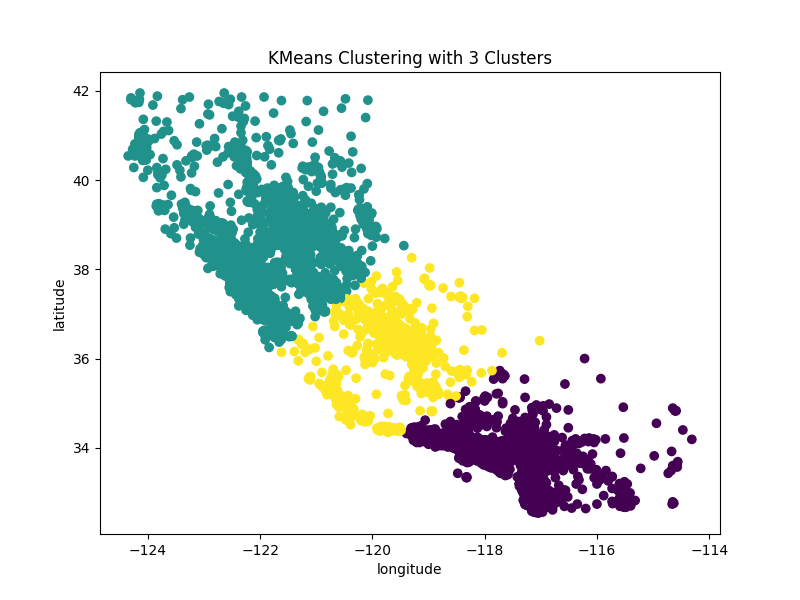

In [50]:
# Test K-means clustering function
kmeans_result = kmeans_clustering(data, n_clusters=3, feature_x='longitude', feature_y='latitude')

# Display the K-means plot
from IPython.display import display, HTML
display(HTML(f"<img src='data:image/png;base64,{kmeans_result['kmeans_plot']}'/>"))

##Button 3: Advanced visualization T-SNE (optional as it takes quite some time with regards to computation, the smaller our data set, the faster it computes it)
This button provides the user with a 2-D visualisation of all the features that normally would make up higher dimensions. In short: try to visualize the multidimensional datA set in two dimensions (2-D)




In [51]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import io
import base64
import pandas as pd

def tsne_visualization(data):
    """
    Perform t-SNE and visualize the results.

    Parameters:
    data (list of dict): List of dictionaries containing the dataset.

    Returns:
    dict: A dictionary containing the base64 encoded plot.
    """
    df = pd.DataFrame(data)
    numeric_features = df.select_dtypes(include='number').columns.tolist()
    selected_features = df[numeric_features]

    tsne_model = TSNE(n_components=2)
    tsne_result = tsne_model.fit_transform(selected_features)

    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
    plt.title('t-SNE Visualization')

    img = io.BytesIO()
    plt.savefig(img, format='png')
    img.seek(0)
    tsne_plot = base64.b64encode(img.getvalue()).decode()
    plt.close()

    return {
        'tsne_plot': tsne_plot
    }



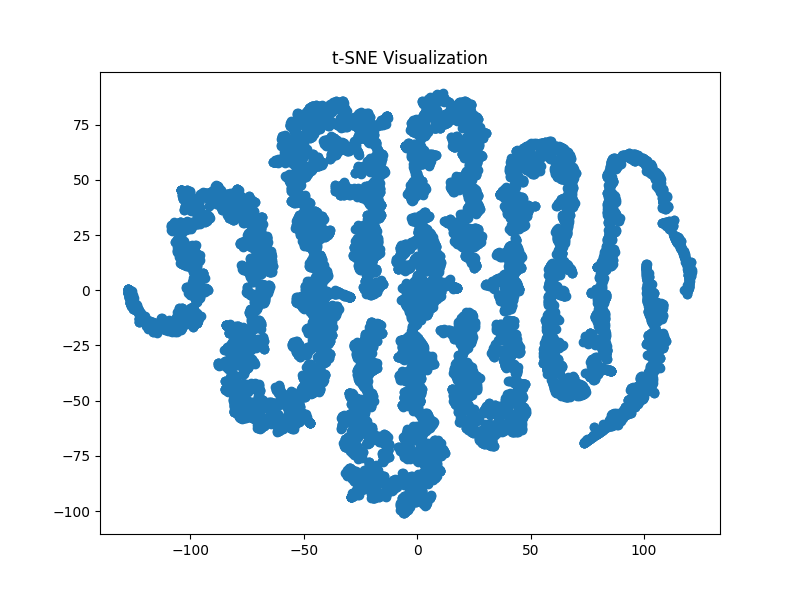

In [52]:
# Test t-SNE visualization function
tsne_result = tsne_visualization(data)

# Display the t-SNE plot
from IPython.display import display, HTML
display(HTML(f"<img src='data:image/png;base64,{tsne_result['tsne_plot']}'/>"))

#Integrating it with Flask: Example code to tinker with and or expand/correct it

In [ ]:
from flask import Flask, request, jsonify
from flask_cors import CORS
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import io
import base64

app = Flask(__name__)
CORS(app)

# Basic Data Analysis Function
def basic_data_analysis(data):
    df = pd.DataFrame(data)

    # Summary Statistics
    summary = df.describe().to_dict()

    # Missing Values
    missing_values = df.isnull().sum().to_dict()

    # Unique Values
    unique_values = df.nunique().to_dict()

    # Histograms
    histograms = {}
    for column in df.select_dtypes(include=['number']).columns:
        plt.figure()
        df[column].hist()
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')

        img = io.BytesIO()
        plt.savefig(img, format='png')
        img.seek(0)
        histograms[column] = base64.b64encode(img.getvalue()).decode()
        plt.close()

    # Correlation Matrix
    plt.figure(figsize=(10, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix')

    img = io.BytesIO()
    plt.savefig(img, format='png')
    img.seek(0)
    correlation_matrix = base64.b64encode(img.getvalue()).decode()
    plt.close()

    return {
        'summary': summary,
        'missing_values': missing_values,
        'unique_values': unique_values,
        'histograms': histograms,
        'correlation_matrix': correlation_matrix
    }

# PCA Feature Importance Function
def pca_feature_importance(data, n_components=None):
    df = pd.DataFrame(data)
    numeric_features = df.select_dtypes(include='number').columns.tolist()
    selected_features = df[numeric_features]

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca.fit(selected_features)

    explained_variance_ratio = pca.explained_variance_ratio_
    feature_importance = pd.DataFrame(pca.components_, columns=numeric_features).abs().mean().sort_values(ascending=False)

    return {
        'explained_variance_ratio': explained_variance_ratio.tolist(),
        'feature_importance': feature_importance.to_dict()
    }

# KMeans Clustering Function
def kmeans_clustering(data, n_clusters=3, feature_x='longitude', feature_y='latitude'):
    df = pd.DataFrame(data)
    selected_features = df[[feature_x, feature_y]]

    kmeans = KMeans(n_clusters=n_clusters)
    df['cluster'] = kmeans.fit_predict(selected_features)

    plt.figure(figsize=(8, 6))
    plt.scatter(df[feature_x], df[feature_y], c=df['cluster'])
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title(f'KMeans Clustering with {n_clusters} Clusters')

    img = io.BytesIO()
    plt.savefig(img, format='png')
    img.seek(0)
    kmeans_plot = base64.b64encode(img.getvalue()).decode()
    plt.close()

    return {
        'kmeans_plot': kmeans_plot
    }

# t-SNE Visualization Function
def tsne_visualization(data):
    df = pd.DataFrame(data)
    numeric_features = df.select_dtypes(include='number').columns.tolist()
    selected_features = df[numeric_features]

    tsne_model = TSNE(n_components=2)
    tsne_result = tsne_model.fit_transform(selected_features)

    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
    plt.title('t-SNE Visualization')

    img = io.BytesIO()
    plt.savefig(img, format='png')
    img.seek(0)
    tsne_plot = base64.b64encode(img.getvalue()).decode()
    plt.close()

    return {
        'tsne_plot': tsne_plot
    }

# Flask Endpoints
@app.route('/basic-analysis', methods=['POST'])
def basic_analysis():
    request_data = request.get_json()
    data = request_data['data']
    result = basic_data_analysis(data)
    return jsonify(result)

@app.route('/pca-feature-importance', methods=['POST'])
def pca_feature_importance_endpoint():
    request_data = request.get_json()
    data = request_data['data']
    n_components = request_data.get('n_components')
    result = pca_feature_importance(data, n_components)
    return jsonify(result)

@app.route('/kmeans-clustering', methods=['POST'])
def kmeans_clustering_endpoint():
    request_data = request.get_json()
    data = request_data['data']
    n_clusters = request_data.get('n_clusters', 3)
    feature_x = request_data.get('feature_x', 'longitude')
    feature_y = request_data.get('feature_y', 'latitude')
    result = kmeans_clustering(data, n_clusters, feature_x, feature_y)
    return jsonify(result)

@app.route('/tsne-visualization', methods=['POST'])
def tsne_visualization_endpoint():
    request_data = request.get_json()
    data = request_data['data']
    result = tsne_visualization(data)
    return jsonify(result)

if __name__ == '__main__':
    app.run()
